In [ ]:
import os
import random
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
import meerkat as mk
from domino import DominoSlicer
from classifer_v6 import *
from bootstrap_meta import *
from sklearn.metrics import accuracy_score
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.mixture import GaussianMixture
from sklearn.metrics.pairwise import cosine_similarity
from bootstrap_meta import *
from matplotlib import pyplot as plt

In [3]:
def parse_embedding(embedding_str):
    if isinstance(embedding_str, str):

        return np.fromstring(embedding_str.strip("[]"), sep=' ')
    elif isinstance(embedding_str, np.ndarray):
        return embedding_str
    else:
        return np.array([])
        
def analyze_error_slice_tokens(slice_df, test_df, k=20, max_features=1000, seed=42):
    most_common_class = slice_df['true'].value_counts().idxmax()
    correct_df = test_df[(test_df['true'] == most_common_class) & (test_df['predicted'] == most_common_class)]

    error_texts = (slice_df['report_text'].fillna('') + ' ' + slice_df['metadata_description'].fillna('')).tolist()
    normal_texts = (correct_df['report_text'].fillna('') + ' ' + correct_df['metadata_description'].fillna('')).tolist()
    all_texts = normal_texts + error_texts
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=(1, 4),
        stop_words="english",
        token_pattern=r'\b[a-zA-Z]{2,}\b'
    )
    tfidf_matrix = vectorizer.fit_transform(all_texts)
    feature_names = vectorizer.get_feature_names_out()
    split_index = len(normal_texts)
    tfidf_array = tfidf_matrix.toarray()
    normal_avg = np.mean(tfidf_array[:split_index], axis=0)
    error_avg = np.mean(tfidf_array[split_index:], axis=0)
    #diff_scores = error_avg - normal_avg
    diff_scores = error_avg - normal_avg
    analyzer = vectorizer.build_analyzer()
    error_tokens = sum((analyzer(t) for t in error_texts), [])
    normal_tokens = sum((analyzer(t) for t in normal_texts), [])
    error_counts = Counter(error_tokens)
    normal_counts = Counter(normal_tokens)
    result_df = pd.DataFrame({
        'token': feature_names,
        'diff_score': diff_scores,
        'error_count': [error_counts[token] for token in feature_names],
        'normal_count': [normal_counts[token] for token in feature_names]
    })
    return result_df.sort_values(by='diff_score', ascending=False).head()

In [4]:


def compute_residual_vectors(emb_incorrect, emb_correct):
    """
    Compute residual vectors by finding the nearest correct embedding for each incorrect embedding.
    This function uses cosine similarity to find the most similar correct embedding for each incorrect embedding.
    """
    similarity_matrix = cosine_similarity(emb_incorrect, emb_correct)
    nearest_indices = similarity_matrix.argmax(axis=1)
    correct_mean = np.mean(emb_correct, axis=0)
    residuals = emb_incorrect - correct_mean
    #residuals = emb_incorrect - emb_correct[nearest_indices]  # Subtract the nearest correct embedding
    #Normalize residuals to unit length
    residuals = normalize(residuals, axis=1, norm='l2')
    return residuals, nearest_indices

def cluster_residuals(residuals, n_components=5):
    """
    Using Gaussian Mixture Model to cluster residual vectors.
    """
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    labels = gmm.fit_predict(residuals)
    return labels, gmm

# def compute_compactness(vectors):
#     """
#     Calculate the compactness of a set of vectors.
#     """
#     centroid = np.mean(vectors, axis=0)
#     squared_dists = np.sum((vectors - centroid) ** 2, axis=1)
#     return np.mean(squared_dists)

def compute_compactness(vectors, epsilon=1e-8):
    """
    Compute a density-based slice quality score.
    The score is defined as: num_samples / (compactness + epsilon)
    where compactness is the mean squared distance to the cluster centroid.
    """
    N = vectors.shape[0]
    if N == 0:
        return 0.0  # avoid division by zero
    centroid = np.mean(vectors, axis=0)
    squared_dists = np.sum((vectors - centroid) ** 2, axis=1)
    compactness = np.mean(squared_dists)
    score = N / (compactness + epsilon)
    return score

def find_error_slices_by_posterior(residuals, gmm, threshold=0.5):
    posterior = gmm.predict_proba(residuals)  # shape [n_samples, n_clusters]
    n_clusters = posterior.shape[1]
    
    slices = []

    for cluster_id in range(n_clusters):

        probs = posterior[:, cluster_id]
        mask = probs > threshold
        indices = np.where(mask)[0]

        if len(indices) == 0:
            continue


        sorted_indices = indices[np.argsort(probs[indices])[::-1]]  # descending

        original_error_indices = np.arange(len(residuals))
        error_mask = np.isin(sorted_indices, original_error_indices)
        error_rate = error_mask.sum() / len(sorted_indices)

        cluster_vectors = residuals[sorted_indices]
        compactness = compute_compactness(cluster_vectors)


        slices.append({
            "cluster_id": cluster_id,
            "num_samples": len(sorted_indices),
            "error_rate": error_rate,
            "compactness": compactness,
            "indices": sorted_indices,   
            "posterior_probs": probs[sorted_indices],  
        })

    return slices


In [5]:
from sklearn.mixture import GaussianMixture
import numpy as np

def discover_error_slices(
    df,
    embedding_col='image_embedding',
    n_components=3,
    threshold=0.5,
    slice_id=None,
    random_state=42,
    return_df=True
):
    """
    Cluster residuals with GMM and extract error slices 
    based on posterior probabilities.

    Args:
        df: DataFrame containing embeddings
        embedding_col: str, column name of embeddings in df
        n_components: number of GMM components (clusters)
        threshold: posterior probability threshold for slice membership
        slice_id: int or None, if given → only return the slice with this id
        random_state: reproducibility
        return_df: bool, if True → also return DataFrame slice with posterior probs

    Returns:
        -  if return_df=False:
            slices (list or dict if slice_id given), gmm, labels
        -  if return_df=True 且 slice_id 指定:
            slice_df (DataFrame subset), gmm, labels
    """

    residuals = np.vstack(df[embedding_col].values)

    gmm = GaussianMixture(n_components=n_components, random_state=random_state)
    labels = gmm.fit_predict(residuals)
    posterior = gmm.predict_proba(residuals)

    slices = []
    n_clusters = posterior.shape[1]
    original_error_indices = np.arange(len(residuals))

    for cluster_id in range(n_clusters):
        probs = posterior[:, cluster_id]
        mask = probs > threshold
        indices = np.where(mask)[0]

        if len(indices) == 0:
            continue

        sorted_indices = indices[np.argsort(probs[indices])[::-1]]

        error_mask = np.isin(sorted_indices, original_error_indices)
        error_rate = error_mask.sum() / len(sorted_indices)

        cluster_vectors = residuals[sorted_indices]
        compactness = compute_compactness(cluster_vectors)

        slice_info = {
            "cluster_id": cluster_id,
            "num_samples": len(sorted_indices),
            "error_rate": error_rate,
            "compactness": compactness,
            "indices": sorted_indices,
            "posterior_probs": probs[sorted_indices],
        }

        slices.append(slice_info)

    if slice_id is not None:
        selected = [s for s in slices if s["cluster_id"] == slice_id]
        if len(selected) == 0:
            return None, gmm, labels

        if return_df:
            s = selected[0]
            slice_df = df.iloc[s["indices"]].copy()
            slice_df["posterior_prob"] = s["posterior_probs"]
            return slice_df, gmm, labels
        else:
            return selected[0], gmm, labels

    return slices, gmm, labels


In [6]:
test_df = pd.read_parquet("/vol/bitbucket/yl28218/thesis/mimic_cxr_exp/results/exp1/test_results_exp1.parquet")
#test_df = pd.read_parquet('test_results_support_devices_for_clustering.parquet')
#test_df['combined'] = test_df['image_embedding'].apply(parse_embedding)
test_df["image_embedding"] = test_df['image_embedding'].apply(parse_embedding)
test_df['report_embedding'] = test_df['report_embedding'].apply(parse_embedding)
test_df['metadata_embedding'] = test_df['metadata_embedding'].apply(parse_embedding)
test_df['combined_emebdding'] = test_df['combined_embedding'].apply(parse_embedding)
test_df['combined_emebdding_v2'] = test_df['combined_emebdding_v2'].apply(parse_embedding)
test_df['combined_emebdding_v3'] = test_df['combined_embedding_v3'].apply(parse_embedding)
test_df['combined_emebdding_v4'] = test_df['combined_embedding_v4'].apply(parse_embedding)

#test_df['combined_emebdding_v2'] = test_df['combined_emebdding_v2'].apply(parse_embedding)
test_df_1 = test_df[test_df["true"] == 1].copy()
test_df_0 = test_df[test_df["true"] == 0].copy()

test_df_1_correct = test_df_1[test_df_1["predicted"] == 1].copy()
test_df_0_correct = test_df_0[test_df_0["predicted"] == 0].copy()
test_df_1_incorrect = test_df_1[test_df_1["predicted"] == 0].copy()
test_df_0_incorrect = test_df_0[test_df_0["predicted"] == 1].copy()

print(f"Number of correct positive predictions: {len(test_df_1_correct)}")
print(f"Number of incorrect positive predictions: {len(test_df_1_incorrect)}")
print(f"Number of correct negative predictions: {len(test_df_0_correct)}")
print(f"Number of incorrect negative predictions: {len(test_df_0_incorrect)}")

Number of correct positive predictions: 78
Number of incorrect positive predictions: 40
Number of correct negative predictions: 96
Number of incorrect negative predictions: 86


In [7]:
slice1_img, gmm_img, labels_img = discover_error_slices(
    df=test_df_1_incorrect,
    embedding_col='image_embedding',
    n_components=3,
    threshold=0.5,
    slice_id=1,
    return_df=True
)

print(slice1_img[["Support Devices", "posterior_prob"]].head())


     Support Devices  posterior_prob
285                1             1.0
121                1             1.0
2                  1             1.0
21                 0             1.0
32                 0             1.0


In [8]:
slice1_comb, gmm_comb, labels_comb = discover_error_slices(
    df=test_df_1_incorrect,
    embedding_col='combined_emebdding', 
    n_components=3,
    threshold=0.5,
    slice_id=1,
    return_df=True
)

print(slice1_comb[["Support Devices", "posterior_prob"]].head())



     Support Devices  posterior_prob
285                1             1.0
121                1             1.0
2                  1             1.0
21                 0             1.0
32                 0             1.0


In [9]:
slice1_comb2, gmm_comb2, labels_comb2 = discover_error_slices(
    df=test_df_1_incorrect,
    embedding_col='combined_emebdding_v2',
    n_components=3,
    threshold=0.5,
    slice_id=1,
    return_df=True
)

print(slice1_comb2[["Support Devices", "posterior_prob"]].head())


     Support Devices  posterior_prob
285                1             1.0
267                1             1.0
2                  1             1.0
21                 0             1.0
32                 0             1.0


In [10]:
slice1_report, gmm_report, labels_report = discover_error_slices(
    df=test_df_1_incorrect,
    embedding_col='report_embedding',
    n_components=3,
    threshold=0.5,
    slice_id=2,
    return_df=True
)

print(slice1_report[["Support Devices", "posterior_prob"]].head())


     Support Devices  posterior_prob
206                0             1.0
153                1             1.0
65                 0             1.0
48                 1             1.0
2                  1             1.0


In [11]:
slice1_meta, gmm_meta, labels_meta = discover_error_slices(
    df=test_df_1_incorrect,
    embedding_col='metadata_embedding',
    n_components=3,
    threshold=0.5,
    slice_id=1,
    return_df=True
)

print(slice1_meta[["Support Devices", "posterior_prob"]].head())


     Support Devices  posterior_prob
285                1             1.0
267                1             1.0
2                  1             1.0
21                 0             1.0
32                 0             1.0


In [12]:
slice1_comb2, gmm_comb2, labels_comb2 = discover_error_slices(
    df=test_df_1_incorrect,
    embedding_col='combined_emebdding_v2',
    n_components=3,
    threshold=0.5,
    slice_id=1,
    return_df=True
)

print(slice1_comb2[["Support Devices", "posterior_prob"]].head())


     Support Devices  posterior_prob
285                1             1.0
267                1             1.0
2                  1             1.0
21                 0             1.0
32                 0             1.0


In [13]:
slice1_comb4, gmm_comb4, labels_comb4 = discover_error_slices(
    df=test_df_1_incorrect,
    embedding_col='combined_emebdding_v4',
    n_components=3,
    threshold=0.5,
    slice_id=1,
    return_df=True
)
print(slice1_comb4[["Support Devices", "posterior_prob"]].head())


     Support Devices  posterior_prob
285                1             1.0
121                1             1.0
2                  1             1.0
21                 0             1.0
32                 0             1.0


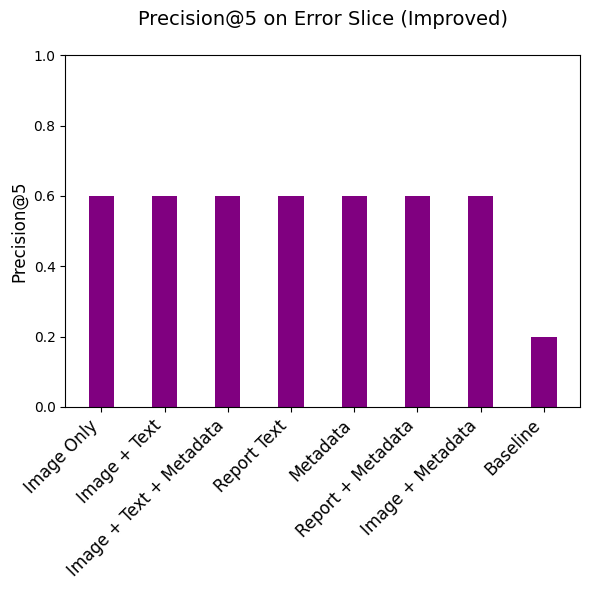

In [ ]:
k = 5
# the values are obtained from the previous analysis and baselibe is from previous iteration
precision_values = [
    0.6,
    0.6,
    0.6,
    0.6,
    0.6,
    0.6,
    0.6,
    0.2,
]

embedding_types = [
    "Image Only",
    "Image + Text",
    "Image + Text + Metadata",
    "Report Text",
    "Metadata",
    "Report + Metadata",
    "Image + Metadata",
    "Baseline"
    
]

plt.figure(figsize=(6, 6))
bars = plt.bar(embedding_types, precision_values, color="Purple",width=0.4)

# for bar, value in zip(bars, precision_values):
#     plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
#              f"{value:.4f}", ha='center', va='bottom', fontsize=12)

plt.title(
    f"Precision@{k} on Error Slice (Improved)\n",
    fontsize=14
)
plt.ylabel(f"Precision@{k}", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.ylim(0, 1)  
plt.tight_layout()
plt.show()

In [44]:
tokens_slice_1 = analyze_error_slice_tokens(slice1_img, test_df, 10, max_features=1000, seed=42)
tokens_slice_2 = analyze_error_slice_tokens(slice1_comb, test_df, 10, max_features=1000, seed=42)
tokens_slice_3 = analyze_error_slice_tokens(slice1_report, test_df, 10, max_features=1000, seed=42)
tokens_slice_4 = analyze_error_slice_tokens(slice1_meta, test_df, 10, max_features=1000, seed=42)
tokens_slice_5 = analyze_error_slice_tokens(slice1_comb2, test_df, 10, max_features=1000, seed=42)
tokens_slice_6 = analyze_error_slice_tokens(slice1_comb4, test_df, 10, max_features=1000, seed=42)
tokens_slice_7 = analyze_error_slice_tokens(slice1_comb4, test_df, 10, max_features=1000, seed=42)

In [18]:
tokens_slice_1.head()

,token,diff_score,error_count,normal_count
89,catheter,0.022811,20,29
985,visualized,0.021817,7,2
42,appears slightly,0.020721,6,1
764,removed,0.018051,5,3
26,ap radiograph chest,0.017699,5,3


In [19]:
tokens_slice_2.head()

,token,diff_score,error_count,normal_count
89,catheter,0.022811,20,29
985,visualized,0.021817,7,2
42,appears slightly,0.020721,6,1
764,removed,0.018051,5,3
26,ap radiograph chest,0.017699,5,3


In [46]:
tokens_slice_3

,token,diff_score,error_count,normal_count
982,visualized,0.058485,3,2
27,ap radiograph chest,0.058256,3,3
26,ap radiograph,0.058256,3,3
705,radiograph chest,0.051556,3,5
313,final report reason examination,0.051514,2,2


In [21]:
tokens_slice_4.head()

,token,diff_score,error_count,normal_count
593,picc,0.023943,8,6
88,catheter,0.021203,20,29
25,ap radiograph chest,0.020884,6,3
24,ap radiograph,0.020884,6,3
986,visualized,0.020718,7,2


In [22]:
tokens_slice_5.head()

,token,diff_score,error_count,normal_count
593,picc,0.023943,8,6
88,catheter,0.021203,20,29
25,ap radiograph chest,0.020884,6,3
24,ap radiograph,0.020884,6,3
986,visualized,0.020718,7,2


In [23]:
tokens_slice_6.head()

,token,diff_score,error_count,normal_count
604,picc,0.022873,8,6
985,visualized,0.020156,7,2
25,ap radiograph,0.019863,6,3
26,ap radiograph chest,0.019863,6,3
90,catheter,0.019777,20,29


In [24]:
tokens_slice_7.head()

,token,diff_score,error_count,normal_count
604,picc,0.022873,8,6
985,visualized,0.020156,7,2
25,ap radiograph,0.019863,6,3
26,ap radiograph chest,0.019863,6,3
90,catheter,0.019777,20,29


In [38]:
tokens_slice_8 = analyze_error_slice_tokens(test_df, test_df, 10, max_features=1000, seed=42)
tokens_slice_8.head()

,token,diff_score,error_count,normal_count
449,left,0.024106,383,67
932,tube,0.023873,176,20
33,apical,0.021902,98,3
806,right,0.021579,492,101
34,apical pneumothorax,0.018557,78,2
